In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import json
# from src.utils import program_to_dsl, dsl_to_program
import seaborn as sns

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# init examples: 10, # data: 20, f1_median: 1.0, runtime_median: 392.0
# init examples: 15, # data: 20, f1_median: 1.0, runtime_median: 391.0
# init examples: 10, # data: 20, f1_median: 0.949, runtime_median: 443.0
# init examples: 15, # data: 20, f1_median: 0.941, runtime_median: 429.0
# init examples: 10, # data: 20, f1_median: 0.41, runtime_median: 441.0
# init examples: 15, # data: 20, f1_median: 0.791, runtime_median: 600.0
# init examples: 10, # data: 20, f1_median: 0.975, runtime_median: 346.0
# init examples: 15, # data: 20, f1_median: 0.992, runtime_median: 335.0
# init examples: 10, # data: 20, f1_median: 0.983, runtime_median: 295.0
# init examples: 15, # data: 20, f1_median: 0.946, runtime_median: 310.0
# init examples: 10, # data: 20, f1_median: 0.312, runtime_median: 445.0
# init examples: 15, # data: 20, f1_median: 0.406, runtime_median: 456.0


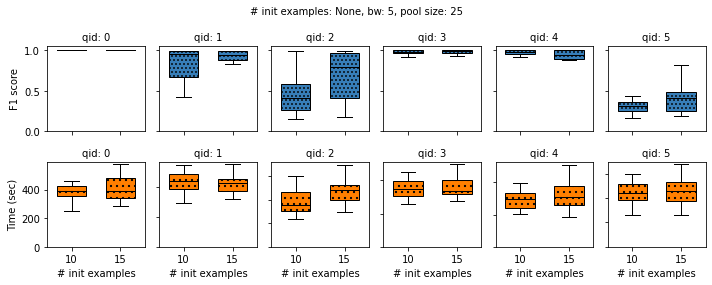

In [6]:
def plot_scene_graph(init_example, bw, pool_size):
    queries = [
        "(Color_red(o0), Far_3.0(o0, o1), Shape_cylinder(o1)); Near_1.0(o0, o1)",
        "(Color_red(o0), Far_3.0(o0, o1), Shape_cylinder(o1)); (Near_1.0(o0, o1), RightQuadrant(o2), TopQuadrant(o2))",
        "Duration((Color_red(o0), Far_3.0(o0, o1), Shape_cylinder(o1)), 25); (Near_1.0(o0, o1), RightQuadrant(o2), TopQuadrant(o2))",
        "(Behind(o0, o1), BottomQuadrant(o1), Color_purple(o0), material_metal(o0))",
        "(Behind(o0, o1), BottomQuadrant(o1), Color_purple(o0), material_metal(o0)); TopQuadrant(o1)",
        "(Behind(o0, o1), BottomQuadrant(o1), Color_purple(o0), material_metal(o0)); TopQuadrant(o1); Duration((BottomQuadrant(o2), RightQuadrant(o2)), 25)"
    ]
    pool_sizes = [25, 50, 100]
    init_examples = [10, 15]
    bws = [5, 7, 10]
    if init_example is None: 
        plot_vars = init_examples
        var_name = "# init examples"
    elif bw is None: 
        plot_vars = bws
        var_name = "bw"
    elif pool_size is None: 
        plot_vars = pool_sizes
        var_name = "pool size"
    exp_dir = "/gscratch/balazinska/enhaoz/complex_event_video/outputs/user_study_queries_scene_graph/stats/vocal_postgres-topk"
    
    fig, axs = plt.subplots(2, len(queries), figsize = (10, 4))
    
    
    for qid, query in enumerate(queries):
        
        handles_f1 = []
        handles_runtime = []
        legend_labels = []

        f1_data = []
        runtime_data = []
        for plot_var in plot_vars:
            f1 = []
            runtime = []
            if init_example is None: 
                dir_name = os.path.join(exp_dir, "nip_{}-nin_{}-npred_7-depth_3-max_d_75-nvars_3-bw_{}-pool_size_{}-n_sampled_videos_100-k_100-budget_50-thread_4-lru_None-lambda_0.001".format(plot_var, plot_var, bw, pool_size))
            elif bw is None: 
                dir_name = os.path.join(exp_dir, "nip_{}-nin_{}-npred_7-depth_3-max_d_75-nvars_3-bw_{}-pool_size_{}-n_sampled_videos_100-k_100-budget_50-thread_4-lru_None-lambda_0.001".format(init_example, init_example, plot_var, pool_size))
            elif pool_size is None: 
                dir_name = os.path.join(exp_dir, "nip_{}-nin_{}-npred_7-depth_3-max_d_75-nvars_3-bw_{}-pool_size_{}-n_sampled_videos_100-k_100-budget_50-thread_4-lru_None-lambda_0.001".format(init_example, init_example, bw, plot_var))
            with open(os.path.join(dir_name, "{}.json".format(query)), "r") as f:
                stats = json.load(f)
            f1.extend(stats["score_median"])
            runtime.extend(stats["runtime"])

            f1 = np.array(f1)
            runtime = np.array(runtime)
            if np.all(f1 == -1):
                f1 = np.zeros_like(f1)
            else:
                f1[f1 == -1] = np.nan
            f1 = f1[~np.isnan(f1)]
            if np.all(runtime == -1):
                runtime = np.zeros_like(runtime)
            else:
                runtime[runtime == -1] = np.nan
            runtime = runtime[~np.isnan(runtime)]
            print("{}: {}, # data: {}, f1_median: {}, runtime_median: {}".format(var_name, plot_var, len(f1), np.round(np.median(f1), 3), np.round(np.median(runtime))))
            f1_data.append(f1)
            runtime_data.append(runtime)

        bp_f1 = axs[0][qid].boxplot(f1_data, 
                       positions=np.array(range(len(f1_data))), 
                       sym='.', widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[0], hatch = '...'),
                       medianprops = dict(color='black'))   
        bp_runtime = axs[1][qid].boxplot(runtime_data, 
                       positions=np.array(range(len(runtime_data))), 
                       sym='.', widths=0.6, showfliers=False, patch_artist=True, boxprops=dict(facecolor=CB_color_cycle[1], hatch = '..'),
                       medianprops = dict(color='black'))   
        handles_f1.append(bp_f1["boxes"][0])
        handles_runtime.append(bp_runtime["boxes"][0])
        
        axs[0][qid].set(xlabel=var_name, ylabel="F1 score")
        axs[0][qid].set_ylim(bottom=0, top=1.05)
        axs[0][qid].set_xticks(range(0, len(plot_vars), 1), plot_vars)
        axs[0][qid].set_title("qid: {}".format(qid), fontsize=10)
        
        axs[1][qid].set(xlabel=var_name, ylabel="Time (sec)")
#         axs[1][qid].set_ylim(bottom=0, top=1.05)
        axs[1][qid].set_xticks(range(0, len(plot_vars), 1), plot_vars)
        axs[1][qid].set_title("qid: {}".format(qid), fontsize=10)
        axs[1][qid].set_ylim(bottom=0)
    #     ax.set_yscale('log')
#         ax.set_xticks(range(0, len(cpu_values), 1), cpu_values)
    for ax in axs.flat:
        ax.label_outer()
    plt.subplots_adjust(bottom=0.15)
    fig.suptitle("# init examples: {}, bw: {}, pool size: {}".format(init_example, bw, pool_size), fontsize=10)
    fig.tight_layout()
    
#     plt.savefig("figures/vary_cpu.pdf", bbox_inches='tight', pad_inches=0, dpi=600)

# plot_scene_graph(init_example=10, bw=7, pool_size=None)
# plot_scene_graph(init_example=15, bw=7, pool_size=None)
# plot_scene_graph(init_example=10, bw=10, pool_size=None)
# plot_scene_graph(init_example=15, bw=10, pool_size=None)

plot_scene_graph(init_example=None, bw=5, pool_size=25)
# plot_scene_graph(init_example=None, bw=7, pool_size=50)
# plot_scene_graph(init_example=None, bw=7, pool_size=100)

# plot_scene_graph(init_example=10, bw=None, pool_size=25)
# plot_scene_graph(init_example=15, bw=None, pool_size=25)
# plot_scene_graph(init_example=10, bw=None, pool_size=25)